In [1]:
from train_latent_space import (
    BRepDS, 
    BRepFaceAutoencoder, 
    BRepFaceEncoder, 
    implicit_part_to_data, 
    ImplicitPart, 
    ImplicitDecoder
)
import meshplot as mp
from pspy import Part, PartOptions
import numpy as np
import torch
from torch_geometric.transforms import SamplePoints
from torch_geometric.data import Data as TGData
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from chamferdist import ChamferDistance


In [2]:
data_root = '/media/ben/Data/cad'
model_checkpoint_path = data_root + '/BRepFaceAutoencoder_64_1024_4.ckpt'
cube_path = data_root + '/cubes/cube.x_t'
long_cube_path = data_root + '/cubes/long_cube.x_t'
angled_cube_path = data_root + '/cubes/angled_cube.x_t'

/tmp/ipykernel_35037/155019579.py:8: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811803361/work/torch/csrc/utils/tensor_numpy.cpp:189.)
  angled_F = torch.from_numpy(angled_part.mesh.F).T.long()
/home/ben/anaconda3/envs/automate/lib/python3.9/site-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811803361/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/ben/anaconda3/envs/automate/lib/python3.9/site-packages/jupyter_client/session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.002746…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.005689…

1

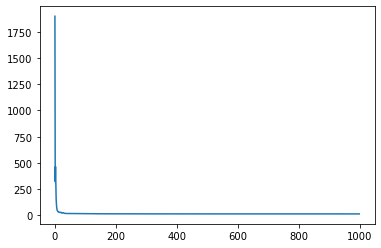

In [3]:

sampler = SamplePoints(6*1000)

chamferDist = ChamferDistance()
opts = PartOptions()
opts.normalize = True
angled_part = Part(angled_cube_path, opts)
angled_V = torch.from_numpy(2*angled_part.mesh.V)
angled_F = torch.from_numpy(angled_part.mesh.F).T.long()
angled_data = TGData(pos=angled_V, face=angled_F)
sampler(angled_data)
target_pc = angled_data.pos
target = target_pc.unsqueeze(0).float().cuda()

ipart = ImplicitPart(cube_path, 10, 100, True)
data = implicit_part_to_data(ipart, 10).cuda()
data.face_surfaces = data.face_surfaces.float()
data.face_surfaces.requires_grad = True
data.edge_curves = data.edge_curves.float()
data.edge_curves.requires_grad = True
data.vertex_positions.requires_grad = True
data.face_surface_parameters.requires_grad = True
data.edge_curve_parameters.requires_grad = True

model = BRepFaceAutoencoder(64,1024,4)
ckpt = torch.load(model_checkpoint_path)
model.load_state_dict(ckpt['state_dict'])

n_faces = 6
N = 50
line = torch.linspace(-0.1,1.1,N)
grid = torch.cartesian_prod(line, line)
grids = grid.repeat(n_faces,1)
indices = torch.arange(n_faces).repeat_interleave(N*N, dim=0)


model = model.cuda()
grids = grids.cuda()
indices = indices.cuda()

opt = torch.optim.SGD(
    [
        data.face_surfaces,
        data.edge_curves,
        data.edge_curve_parameters,
        data.vertex_positions,
        data.face_surface_parameters
    ], 
    lr=0.001, 
    momentum=0.5)

losses = []
predictions = []

num_iters = 1000

for iter in tqdm(range(num_iters)):
    opt.zero_grad()
    pred = model(data, grids, indices)
    pred_xyz = pred[:,:3].unsqueeze(0).float()
    pred_m = pred[:,3].unsqueeze(0).float()
    loss = chamferDist(pred_xyz, target) + chamferDist(target, pred_xyz)
    loss.backward()
    opt.step()
    losses.append(loss.detach().item())
    predictions.append((pred_xyz.detach().cpu().numpy(), pred_m.detach().cpu().numpy()))
    #print(loss)
plt.plot(losses)
i = 0
plot1 = mp.plot(
    predictions[i][0][0,:,:],
    c=predictions[i][1][0,:],
    shading={'point_size':0.1},
    return_plot = True)
plot1.add_points(target_pc.numpy(), shading={'point_size':0.1, 'point_color':'red'})

i = num_iters - 1
plot2 =mp.plot(
    predictions[i][0][0,:,:],
    c=predictions[i][1][0,:],
    shading={'point_size':0.1},
    return_plot=True)
plot2.add_points(target_pc.numpy(), shading={'point_size':0.1, 'point_color':'red'})

In [228]:
import math
import OCC.Core.BRepBuilderAPI as BRepBuilderAPI
import OCC.Core.Geom as Geom
from OCC.Core.GeomAPI import GeomAPI_IntSS, GeomAPI_ExtremaCurveCurve
from OCC.Core.Extrema import Extrema_POnCurv
from OCC.Core.gp import gp_Pnt, gp_Lin, gp_Ax1, gp_Dir, gp_Elips, gp_Ax2
from OCC.Core.BRepBuilderAPI import (
    BRepBuilderAPI_MakeEdge, 
    BRepBuilderAPI_MakeVertex, 
    BRepBuilderAPI_MakeFace,
    BRepBuilderAPI_MakeWire,
    BRepBuilderAPI_MakeShell,
    BRepBuilderAPI_MakeSolid   
)
from OCC.Core.BRep import BRep_Builder
from OCC.Core.TColgp import TColgp_Array1OfPnt
from OCC.Core.Geom import Geom_BezierCurve
from OCC.Display.WebGl.jupyter_renderer import JupyterRenderer
from OCC.Core.TopoDS import TopoDS_Shell, TopoDS_Face, TopoDS_Solid


In [226]:
surface_types = data.face_surfaces.argmax(dim=1)
def make_plane(params):
    return Geom.Geom_Plane(gp_Pnt(*params[:3]), gp_Dir(*params[3:6]))
def make_geom(surface_type, params):
    if surface_type == 0:
        return make_plane(params)
    elif surface_type == 1:
        return make_cylinder(params)
    elif surface_type == 2:
        return make_cone(params)
    elif surface_type == 3:
        return make_sphere(params)
    elif surface_type == 4:
        return make_torus(params)
surfaces = [make_geom(surface_types[i].detach().cpu().item(), data.face_surface_parameters[i].detach().cpu().tolist())
    for i in range(len(surface_types))
]
# find and make the edges using surface intersections

loop_faces = {}
for i in range(data.face_to_loop.shape[1]):
    face = data.face_to_loop[0][i].item()
    loop = data.face_to_loop[1][i].item()
    loop_faces[loop] = face

edge_faces = {}
for i in range(data.loop_to_edge.shape[1]):
    loop = data.loop_to_edge[0][i].cpu().item()
    edge = data.loop_to_edge[1][i].cpu().item()
    edge_faces[edge] = edge_faces.get(edge,[]) + [loop_faces[loop]]

curves = {}
curve_types = {}
for edge,[f1,f2] in edge_faces.items():
    intersection = GeomAPI_IntSS(surfaces[f1], surfaces[f2], 10e-16)
    assert(intersection.IsDone())
    curves[edge] = intersection.Line(1)
    curve_types[edge] = curves[edge].DynamicType().Name()
data.edge_to_vertex
vertex_edges = {}
edge_vertices = {}
for i in range(data.edge_to_vertex.shape[1]):
    edge = data.edge_to_vertex[0][i].cpu().item()
    vertex = data.edge_to_vertex[1][i].cpu().item()
    vertex_edges[vertex] = vertex_edges.get(vertex,[]) + [edge]
    edge_vertices[edge] = edge_vertices.get(edge,[]) + [vertex]
points = {}
for v,cs in vertex_edges.items():
    if len(cs) < 2:
        continue
    extrema = GeomAPI_ExtremaCurveCurve(curves[cs[0]],curves[cs[1]])
    ext = extrema.Extrema()
    p1 = Extrema_POnCurv()
    p2 = Extrema_POnCurv()
    ext.Points(1,p1,p2)
    points[v] = p1.Value()
vertices = {}
for k,v in points.items():
    vertices[k] = BRepBuilderAPI_MakeVertex(v).Vertex()
edges = {}
for k,v in curves.items():
    edges[k] = BRepBuilderAPI_MakeEdge(v,vertices[edge_vertices[k][0]], vertices[edge_vertices[k][1]]).Edge()
wire_edges = {}
for i in range(data.loop_to_edge.shape[1]):
    loop = data.loop_to_edge[0][i].cpu().item()
    edge = data.loop_to_edge[1][i].cpu().item()
    wire_edges[loop] = wire_edges.get(loop,[]) + [edge]
wires = {}
for w, es in wire_edges.items():
    #wire = BRepBuilderAPI_MakeWire(*[edges[e] for e in es])
    wire = BRepBuilderAPI_MakeWire()
    for e in es:
        wire.Add(edges[e])
    wires[w] = wire.Wire()
face_loops = {}
for i in range(data.face_to_loop.shape[1]):
    face = data.face_to_loop[0][i].cpu().item()
    loop = data.face_to_loop[1][i].cpu().item()
    face_loops[face] = face_loops.get(face, []) + [loop]
faces = {}
for k,v in face_loops.items():
    f = BRepBuilderAPI_MakeFace()
    f.Init(surfaces[k],False,10e-8)
    for w in v:
        f.Add(wires[w])
    f.Add(wires[0])
    faces[k] = f.Face()


In [234]:
builder = BRep_Builder()
shell = TopoDS_Shell()
builder.MakeShell(shell)
for f in faces.values():
    builder.Add(shell, f)
solid = TopoDS_Solid()
builder.MakeSolid(solid)
builder.Add(solid, shell)

In [244]:
from OCC.Core.STEPControl import STEPControl_Writer, STEPControl_AsIs
from OCC.Core.IFSelect import IFSelect_RetDone

In [247]:
# Based On
# https://cpp.hotexamples.com/examples/-/STEPControl_Writer/-/cpp-stepcontrol_writer-class-examples.html
writer = STEPControl_Writer()
status =writer.Transfer(solid, STEPControl_AsIs)
writer.Write('test_out.step')


*******************************************************************
******        Statistics on Transfer (Write)                 ******

*******************************************************************
******        Transfer Mode = 0  I.E.  As Is       ******
******        Transferring Shape, ShapeType = 2                      ******


1

** WorkSession : Sending all data
 Step File Name : test_out.step(356 ents)  Write  Done


In [246]:
# Output looks like it has some flipped normals - didn't check face orientations

True

In [149]:
BRepBuilderAPI_MakeEdge(curves[0]).Edge()

<class 'TopoDS_Edge'>

In [238]:
my_renderer = JupyterRenderer()

my_renderer.Display(solid.TShape())


my_renderer.Display()

TypeError: unsupported operand type(s) for *: 'TopoDS_TShape' and 'TopoDS_TShape'

In [85]:
extrema = GeomAPI_ExtremaCurveCurve(curves[0], curves[1])
ext = extrema.Extrema()
p1 = OCC.Core.Extrema.Extrema_POnCurv()
p2 = OCC.Core.Extrema.Extrema_POnCurv()
ext.Points(1,p1,p2)

In [88]:
extrema = GeomAPI_ExtremaCurveCurve(curves[0],curves[1])
ext = extrema.Extrema()
p1 = Extrema_POnCurv()
p2 = Extrema_POnCurv()
ext.Points(1,p1,p2)
print(p1.Value().X())

-1.7618106590648541


In [71]:
print(p1.Value().X(), p1.Value().Y(), p1.Value().Z())
print(p2.Value().X(), p2.Value().Y(), p2.Value().Z())


-1.7618106590648541 -0.6779855060555424 -0.9945948559321088
-1.761810659064854 -0.6779855060555423 -0.9945948559321092


In [ ]:
plane1 = Geom.Geom_Plane(gp_Pnt(0,0,0), gp_Dir(1,0,0))
plane2 = Geom.Geom_Plane(gp_Pnt(0,0,0), gp_Dir(0,0,1))

In [30]:
torch.tensor([0.2,0.5,0.2]).tolist()

[0.20000000298023224, 0.5, 0.20000000298023224]

In [153]:
set(ipart2.edge_curves)

{<CurveFunction.CIRCLE: 1>, <CurveFunction.ICURVE: 4>, <CurveFunction.LINE: 0>}

In [10]:
model = BRepFaceAutoencoder(64,1024,4)
ckpt = torch.load(model_checkpoint_path)
model.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [147]:
model = BRepFaceAutoencoder(64,1024,4)
ckpt = torch.load(model_checkpoint_path)
model.load_state_dict(ckpt['state_dict'])
n_faces = len(ipart2.face_surfaces)
N = 50
line = torch.linspace(-0.1,1.1,N)
grid = torch.cartesian_prod(line, line)
grids = grid.repeat(n_faces,1)
indices = torch.arange(n_faces).repeat_interleave(N*N, dim=0)

In [12]:
pred = model(data, grids, indices)

In [ ]:
mp.plot(pred[:,:3].detach().numpy(), c=pred[:,3].detach().numpy(), shading={'point_size':1})

In [47]:
cube_part = Part(cube_path, opts)

In [41]:
pred_xyz = pred[:,:3].detach().numpy()
pred_m = pred[:,3].detach().numpy()


In [43]:
pred_xyz.max(axis=0)

array([1.2384077, 1.2069366, 1.2218487], dtype=float32)

In [69]:
opts = PartOptions()
opts.normalize = True
angled_part = Part(angled_cube_path, opts)
angled_V = torch.from_numpy(2*angled_part.mesh.V)
angled_F = torch.from_numpy(angled_part.mesh.F).T.long()
angled_data = TGData(pos=angled_V, face=angled_F)
sampler(angled_data)
target_pc = angled_data.pos

Data(pos=[6000, 3])

In [68]:
angled_data.pos

tensor([[-0.5508,  0.2843, -0.7887],
        [-0.6832,  0.5774,  0.0289],
        [-0.3737,  0.5774, -0.0206],
        ...,
        [ 0.9981, -0.1620, -0.7818],
        [ 0.4532,  0.5774, -0.3701],
        [-1.0000, -0.5343, -0.6798]], dtype=torch.float64)

In [ ]:
plot = mp.plot(2*angled_part.mesh.V, angled_part.mesh.F, return_plot=True)
plot.add_points(target_pc.numpy(), shading={'point_size':0.3, 'point_color':'red'})
plot.add_points(pred_xyz, c=pred_m, shading={'point_size':.1})

In [18]:
angled = ImplicitPart(angled_cube_path, 1000, 5000, True)

In [25]:
target_pc = np.stack(angled.surface_samples)[:,:,3].reshape((-1,3))

In [ ]:
mp.plot(target_pc, shading={'point_size':.5})

In [ ]:
import torch
from chamferdist import ChamferDistance

#source_cloud = torch.randn(1, 100, 3).cuda()
#target_cloud = torch.randn(1, 50, 3).cuda()



dist_forward = chamferDist(source_cloud, target_cloud)
print(dist_forward.detach().cpu().item())

In [ ]:
i = 9
mp.plot(
    predictions[i][0][0,:,:],
    c=predictions[i][1][0,:],
    shading={'point_size':0.5})

In [89]:
pred = model(data, grids, indices)
pred_xyz = pred[:,:3].unsqueeze(0).float()
pred_m = pred[:,3].unsqueeze(0).float()
loss = chamferDist(pred_xyz, target) + chamferDist(target, pred_xyz)
#loss.backward()
#opt.step()
#losses.append(loss.detach().item())
#params.append(data.face_surface_parameters.detach().numpy())

In [92]:
data.face_surface_parameters.requires_grad

False

In [ ]:
i = num_iters - 1
plot2 =mp.plot(
    predictions[i][0][0,:,:],
    c=predictions[i][1][0,:],
    shading={'point_size':0.1},
    return_plot=True)
plot2.add_points(target_pc.numpy(), shading={'point_size':0.1, 'point_color':'red'})
plot2.add_mesh(angled_V.numpy(), angled_F.T.numpy())

In [80]:
chamferDist(pred_xyz.unsqueeze(0).float(), target_pc.unsqueeze(0).float())

tensor(1644.8860, grad_fn=<MeanBackward0>)

In [85]:
from matplotlib import pyplot as plt

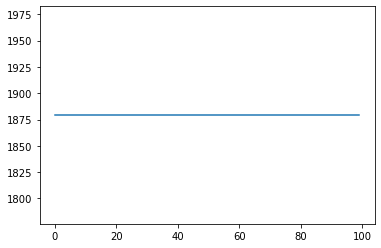

In [86]:
plt.plot(losses)

In [3]:
[x for x in dir(BRepBuilderAPI) if 'Make' in x]

['BRepBuilderAPI_MakeEdge',
 'BRepBuilderAPI_MakeEdge2d',
 'BRepBuilderAPI_MakeFace',
 'BRepBuilderAPI_MakePolygon',
 'BRepBuilderAPI_MakeShape',
 'BRepBuilderAPI_MakeShell',
 'BRepBuilderAPI_MakeSolid',
 'BRepBuilderAPI_MakeVertex',
 'BRepBuilderAPI_MakeWire']

In [10]:
plane = Geom.Geom_Plane(1.0,1.0,0.0,1.0)

In [11]:
plane

<class 'Geom_Plane'>

In [25]:
plane.Axis().Location().Z()

0.0

In [26]:
plane.Axis()

<class 'gp_Ax1'>

In [28]:
loc = gp_Pnt(0, 0, 0)
z_ax = gp_Dir(0,0,1)
x_ax = gp_Dir(1,0,0)

In [50]:
plane1 = Geom.Geom_Plane(gp_Pnt(0,0,0), gp_Dir(1,0,0))
plane2 = Geom.Geom_Plane(gp_Pnt(0,0,0), gp_Dir(0,0,1))

In [54]:
plane_intersection = OCC.Core.GeomAPI.GeomAPI_IntSS(plane1, plane2, 0.0001)
plane_intersection.IsDone()
intersection_curve = plane_intersection.Line(1)
icurve_type = intersection_curve.DynamicType()
icurve_type.Name()

True

'Geom_Line'

In [34]:
face = BRepBuilderAPI.BRepBuilderAPI_MakeFace()

In [37]:
import OCC
import OCC.Core

In [38]:

from OCC.Core.BRepPrimAPI import BRepPrimAPI_MakeBox, BRepPrimAPI_MakeSphere, BRepPrimAPI_MakeCylinder
from OCC.Core.gp import gp_Pnt

In [40]:
box_shape = BRepPrimAPI_MakeBox(10,20,30).Shape()
cylinder_shape = BRepPrimAPI_MakeCylinder(10,30).Shape()

In [ ]:
my_renderer.DisplayShape(
    cylinder_shape, 
    render_edges=True, 
    topo_level="Face", 
    shape_color="#abdda4",
    update=True)

In [44]:
import math

from OCC.Core.gp import (
    gp_Pnt,
    gp_Sphere,
    gp_Ax3,
    gp_Dir,
    gp_Circ,
    gp_Ax2,
    gp_Pnt2d,
    gp_Dir2d,
)
from OCC.Core.BRepBuilderAPI import (
    BRepBuilderAPI_MakeEdge,
    BRepBuilderAPI_MakeFace,
    BRepBuilderAPI_MakeWire,
)
from OCC.Core.TColgp import TColgp_Array2OfPnt
from OCC.Core.GeomAPI import GeomAPI_PointsToBSplineSurface
from OCC.Core.GeomAbs import GeomAbs_C2
from OCC.Core.Geom2d import Geom2d_Line
from OCC.Core.BRepLib import breplib_BuildCurves3d
from OCC.Core.Quantity import Quantity_Color, Quantity_NOC_PINK

In [ ]:
p1 = gp_Pnt()
p2 = gp_Pnt()
p3 = gp_Pnt()
p4 = gp_Pnt()
p5 = gp_Pnt()
p6 = gp_Pnt()

# The white Face
sphere = gp_Sphere(gp_Ax3(gp_Pnt(0, 0, 0), gp_Dir(1, 0, 0)), 150)
green_face = BRepBuilderAPI_MakeFace(sphere, 0.1, 0.7, 0.2, 0.9)

# The red face
p1.SetCoord(-15, 200, 10)
p2.SetCoord(5, 204, 0)
p3.SetCoord(15, 200, 0)
p4.SetCoord(-15, 20, 15)
p5.SetCoord(-5, 20, 0)
p6.SetCoord(15, 20, 35)
array = TColgp_Array2OfPnt(1, 3, 1, 2)
array.SetValue(1, 1, p1)
array.SetValue(2, 1, p2)
array.SetValue(3, 1, p3)
array.SetValue(1, 2, p4)
array.SetValue(2, 2, p5)
array.SetValue(3, 2, p6)
curve = GeomAPI_PointsToBSplineSurface(array, 3, 8, GeomAbs_C2, 0.001).Surface()
red_face = BRepBuilderAPI_MakeFace(curve, 1e-6)

# The brown face
circle = gp_Circ(gp_Ax2(gp_Pnt(0, 0, 0), gp_Dir(1, 0, 0)), 80)
Edge1 = BRepBuilderAPI_MakeEdge(circle, 0, math.pi)
Edge2 = BRepBuilderAPI_MakeEdge(gp_Pnt(0, 0, -80), gp_Pnt(0, -10, 40))
Edge3 = BRepBuilderAPI_MakeEdge(gp_Pnt(0, -10, 40), gp_Pnt(0, 0, 80))

##TopoDS_Wire YellowWire
MW1 = BRepBuilderAPI_MakeWire(Edge1.Edge(), Edge2.Edge(), Edge3.Edge())
if not MW1.IsDone():
    raise AssertionError("MW1 is not done.")
yellow_wire = MW1.Wire()
brown_face = BRepBuilderAPI_MakeFace(yellow_wire)

# The pink face
p1.SetCoord(35, -200, 40)
p2.SetCoord(50, -204, 30)
p3.SetCoord(65, -200, 30)
p4.SetCoord(35, -20, 45)
p5.SetCoord(45, -20, 30)
p6.SetCoord(65, -20, 65)
array2 = TColgp_Array2OfPnt(1, 3, 1, 2)
array2.SetValue(1, 1, p1)
array2.SetValue(2, 1, p2)
array2.SetValue(3, 1, p3)
array2.SetValue(1, 2, p4)
array2.SetValue(2, 2, p5)
array2.SetValue(3, 2, p6)
BSplineSurf = GeomAPI_PointsToBSplineSurface(array2, 3, 8, GeomAbs_C2, 0.001)
aFace = BRepBuilderAPI_MakeFace(BSplineSurf.Surface(), 1e-6).Face()
##
##//2d lines
P12d = gp_Pnt2d(0.9, 0.1)
P22d = gp_Pnt2d(0.2, 0.7)
P32d = gp_Pnt2d(0.02, 0.1)
##
line1 = Geom2d_Line(P12d, gp_Dir2d((0.2 - 0.9), (0.7 - 0.1)))
line2 = Geom2d_Line(P22d, gp_Dir2d((0.02 - 0.2), (0.1 - 0.7)))
line3 = Geom2d_Line(P32d, gp_Dir2d((0.9 - 0.02), (0.1 - 0.1)))
##
##//Edges are on the BSpline surface
Edge1 = BRepBuilderAPI_MakeEdge(
    line1, BSplineSurf.Surface(), 0, P12d.Distance(P22d)
).Edge()
Edge2 = BRepBuilderAPI_MakeEdge(
    line2, BSplineSurf.Surface(), 0, P22d.Distance(P32d)
).Edge()
Edge3 = BRepBuilderAPI_MakeEdge(
    line3, BSplineSurf.Surface(), 0, P32d.Distance(P12d)
).Edge()
##
Wire1 = BRepBuilderAPI_MakeWire(Edge1, Edge2, Edge3).Wire()
Wire1.Reverse()
pink_face = BRepBuilderAPI_MakeFace(aFace, Wire1).Face()
breplib_BuildCurves3d(pink_face)

my_renderer.DisplayShape(green_face.Face())
my_renderer.DisplayShape(red_face.Face())
my_renderer.DisplayShape(pink_face)
my_renderer.DisplayShape(brown_face.Face(),update=True)

#display.DisplayColoredShape(green_face.Face(), "GREEN")
#display.DisplayColoredShape(red_face.Face(), "RED")
#display.DisplayColoredShape(pink_face, Quantity_Color(Quantity_NOC_PINK))
#display.DisplayColoredShape(brown_face.Face(), "BLUE")
#display.DisplayColoredShape(yellow_wire, "YELLOW", update=True)